In [6]:
"""
MULTISCALE TRANSPARENCY FOR TIME SERIES PREDICTION
(Haaris Mian)
Demo for van der Schaar Lab recruitment task.
Uses TIMEVIEW's code for composition extraction.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fft import fft, fftfreq
from basis import BSplineBasis
import numpy as np
import matplotlib.pyplot as plt
import pywt

DEPRECATION: Loading egg at /Users/Haaris/miniconda3/lib/python3.12/site-packages/huggingface_hub-0.26.5-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "font.size": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"
})

In [8]:
#TIMEVIEW'S COMPOSITION EXTRACTION

STATE_NAMES = {
    3: 's++',  # convex_increasing
    4: 's-+',  # concave_increasing
    5: 's+-',  # convex_decreasing
    6: 's--',  # concave_decreasing
}


def fit_bspline_and_extract_composition(t, y, n_basis):
    """Fit B-spline and extract TIMEVIEW composition."""
    basis = BSplineBasis(n_basis=n_basis, t_range=(t.min(), t.max()))
    B = basis.get_matrix(t)
    coeffs = np.linalg.lstsq(B, y, rcond=None)[0]
    y_fit = B @ coeffs
    template, transitions = basis.get_template_from_coeffs(coeffs)
    composition = [STATE_NAMES[s] for s in template]
    return y_fit, composition, transitions


def analyze_timeview_tradeoff(t, y, n_basis_range):
    """Analyze error vs composition length for different basis counts."""
    results = []
    for n_basis in n_basis_range:
        y_fit, composition, transitions = fit_bspline_and_extract_composition(t, y, n_basis)
        rmse = np.sqrt(np.mean((y - y_fit)**2))
        results.append({
            'n_basis': n_basis,
            'rmse': rmse,
            'composition': composition,
            'composition_length': len(composition),
            'y_fit': y_fit,
        })
    return results

In [9]:
def generate_multiscale_signal(t, trend_slope=1.0, osc_amplitude=0.15, osc_frequency=25.0):
    """Generate y(t) = trend + oscillation."""
    y_trend = trend_slope * t
    y_osc = osc_amplitude * np.sin(2 * np.pi * osc_frequency * t)
    return y_trend + y_osc, y_trend, y_osc


def run_experiment():
    """Main comparison experiment."""
    
    t = np.linspace(0, 1, 500)
    y, y_trend, y_osc = generate_multiscale_signal(t)
    
    n_basis_range = [5, 10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90, 100]
    tv_results = analyze_timeview_tradeoff(t, y, n_basis_range)
    return tv_results


def plot_results(t, y, y_trend, tv_results):
    """Generate comparison figure."""
    fig = plt.figure(figsize=(14, 10))
    
    # Panel 1: Tradeoff
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter([r['composition_length'] for r in tv_results], 
                [r['rmse'] for r in tv_results], c='blue', s=100, label='TIMEVIEW')
    ax1.plot([r['composition_length'] for r in tv_results],
             [r['rmse'] for r in tv_results], 'b--', alpha=0.3)
    ax1.set_xlabel('Description Length')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Accuracy vs Interpretability')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Signal + TIMEVIEW
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(t, y, 'b-', alpha=0.5, label='Signal')
    ax2.plot(t, y_trend, 'g--', linewidth=2, label='True trend')
    r5 = next(r for r in tv_results if r['n_basis'] == 5)
    ax2.plot(t, r5['y_fit'], 'orange', linewidth=2, label=f'TIMEVIEW (n=5)')
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('Signal and TIMEVIEW Fit')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


Saved: figure_comparison.png


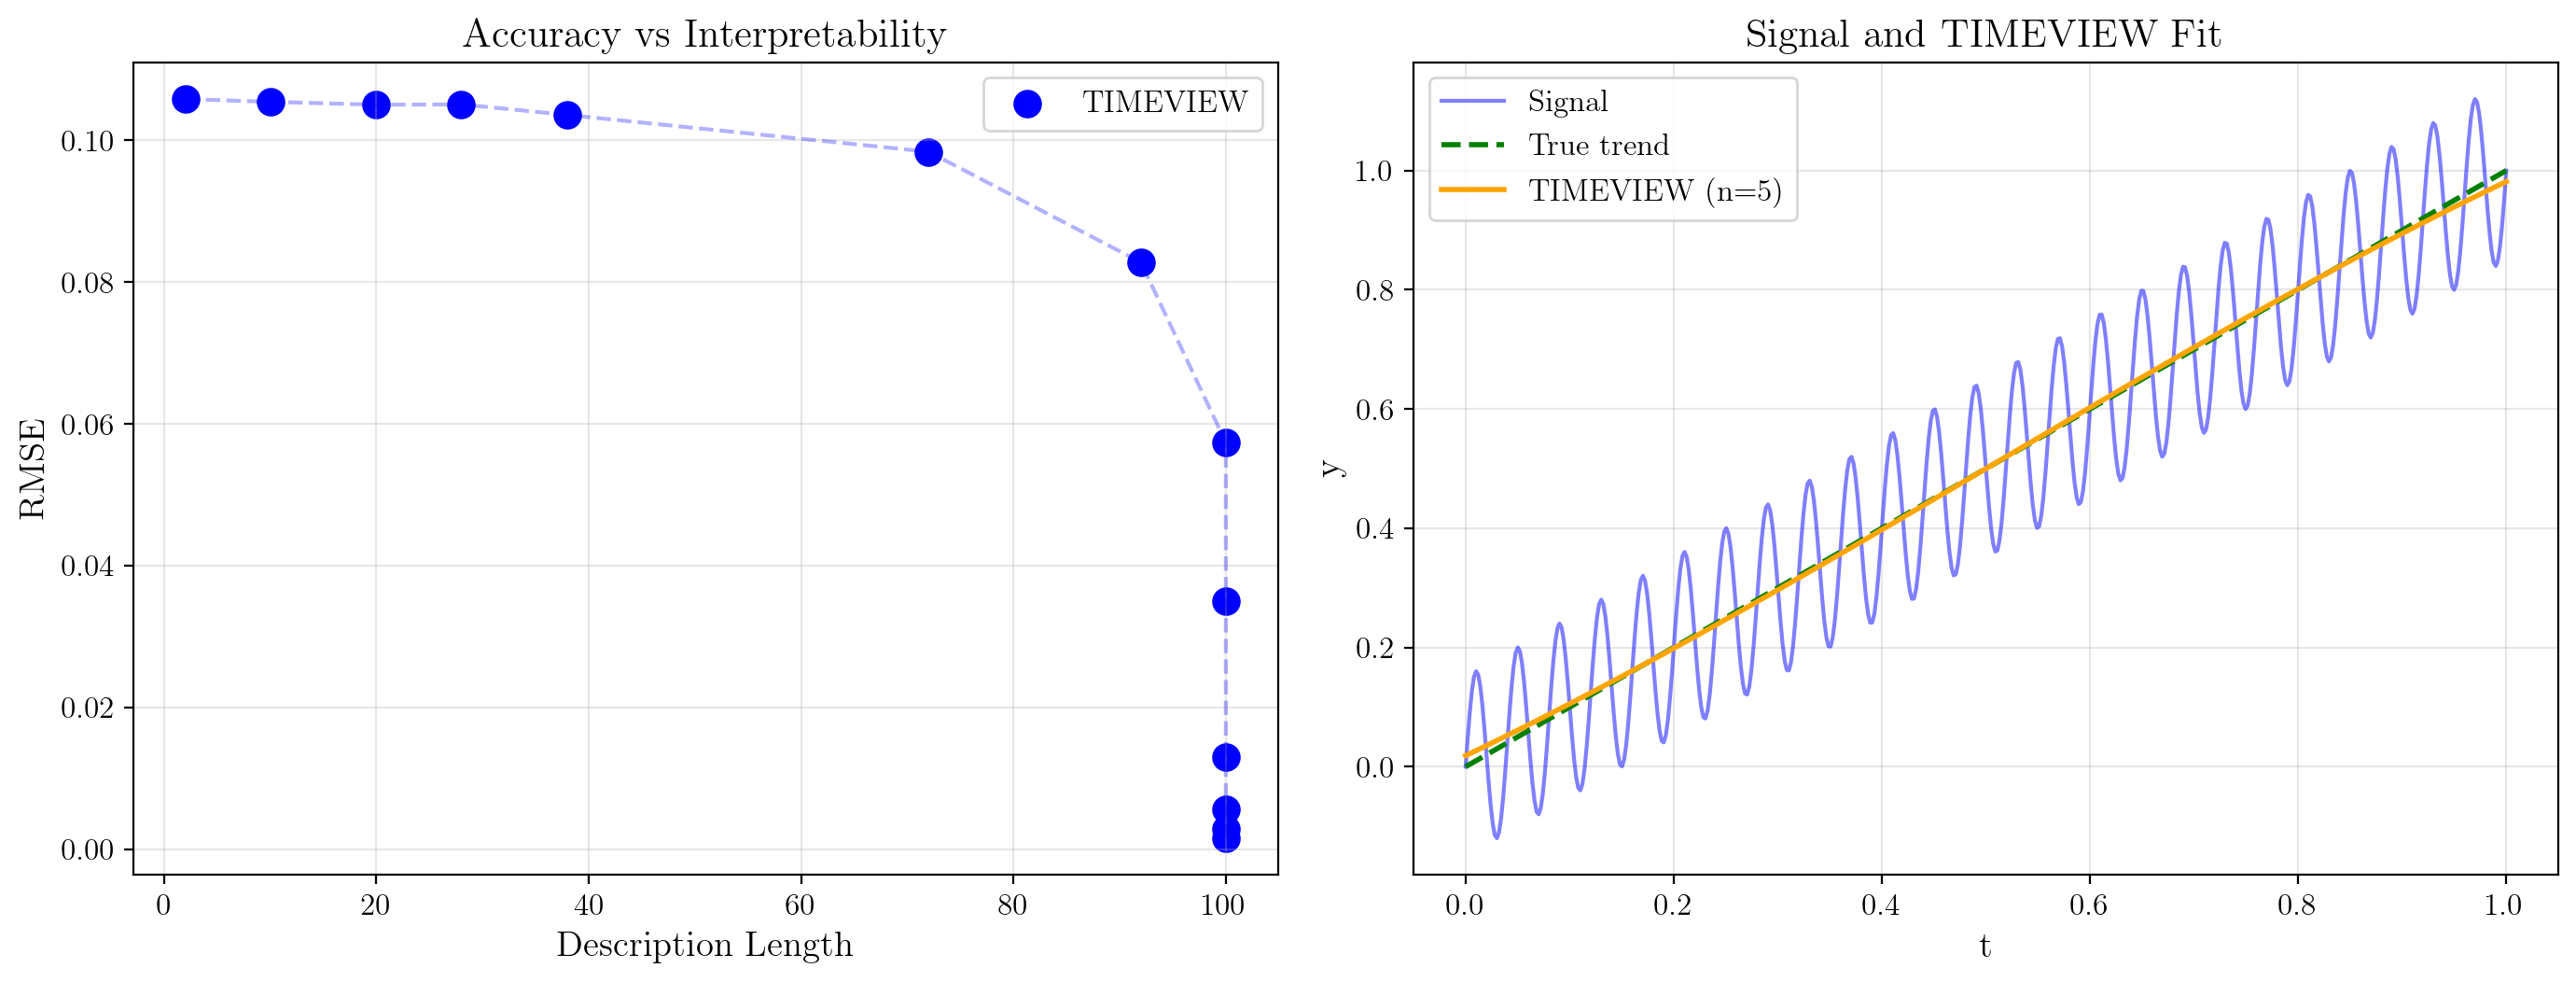

In [10]:
tv_results = run_experiment()

t = np.linspace(0, 1, 500)
y, y_trend, _ = generate_multiscale_signal(t)

fig = plot_results(t, y, y_trend, tv_results)
fig.savefig('figure_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved: figure_comparison.png")
plt.show()

In [16]:
def select_active_scales(trajectories, fs, threshold=0.05, wavelet='db4', max_level=None):
    """
    Data-driven scale selection based on energy content across training set.
    
    This is analogous to TIMEVIEW's knot selection: we determine the wavelet
    decomposition level and active bands BEFORE training, based on global
    properties of the training data.
    """
    # Determine maximum possible decomposition level
    n = len(trajectories[0])
    if max_level is None:
        max_level = min(pywt.dwt_max_level(n, wavelet), 8) # limit to 8 for practicality
    
    # Compute energy in each band across all training trajectories
    band_energies = {j: [] for j in range(1, max_level + 1)}
    
    for y in trajectories:
        # Normalize to remove scale differences across trajectories
        y_normalized = (y - np.mean(y)) / (np.std(y) + 1e-10)
        total_energy = np.sum(y_normalized**2)
        
        # Decompose
        coeffs = pywt.wavedec(y_normalized, wavelet, level=max_level)
        # coeffs = [cA_J, cD_J, cD_{J-1}, ..., cD_1]
        
        # Compute relative energy in each detail band
        for j in range(1, max_level + 1):
            cD_j = coeffs[max_level - j + 1]
            detail_energy = np.sum(cD_j**2)
            rel_energy = detail_energy / (total_energy + 1e-10)
            band_energies[j].append(rel_energy)
    
    # Average across training set
    avg_energies = {j: np.mean(band_energies[j]) for j in band_energies}
    std_energies = {j: np.std(band_energies[j]) for j in band_energies}
    
    # Select active bands (those exceeding threshold)
    active_bands = {j for j in avg_energies if avg_energies[j] >= threshold}
    
    # Optimal level is the deepest active band
    J_star = max(active_bands) if active_bands else 1
    
    # Compile band information
    band_info = {}
    for j in range(1, max_level + 1):
        # freq band range [fs/2^(j+1), fs/2^j]
        freq_low = fs / (2**(j+1))
        freq_high = fs / (2**j)
        band_info[j] = {
            'freq_range': (freq_low, freq_high),
            'avg_energy': avg_energies[j],
            'std_energy': std_energies[j],
            'active': j in active_bands
        }
    
    # Also include approximation band info
    band_info['approx'] = {
        'freq_range': (0, fs / (2**(max_level + 1))),
        'active': True  # always active (coarse component)
    }
    
    return J_star, active_bands, band_info


def print_scale_selection(J_star, active_bands, band_info, fs):
    """print scale selection results."""
    print("AUTOMATED SCALE SELECTION RESULTS")
    print("=" * 70)
    print(f"\nSampling frequency: {fs} Hz")
    print(f"Optimal decomposition level: J* = {J_star}")
    print(f"Active bands: {sorted(active_bands)}")
    
    print(f"\nBand Analysis:")
    print("-" * 70)
    for j in sorted([k for k in band_info if k != 'approx']):
        info = band_info[j]
        freq_lo, freq_hi = info['freq_range']
        status = "ACTIVE" if info['active'] else "inactive"
        print(f"  D_{j}: [{freq_lo:.4f} - {freq_hi:.4f}] Hz | "
              rf"Energy: {info['avg_energy']*100:.2f}% +- {info['std_energy']*100:.2f}% | {status}")
    
    # Approximation
    approx_info = band_info['approx']
    print(f"  A_{J_star}: [0 - {approx_info['freq_range'][1]:.4f}] Hz | COARSE (always active)")

In [17]:
def wavelet_decompose(y, wavelet='db4', level=None):
    """
    Decompose signal into coarse approximation + detail levels.
    
    Returns:
        y_coarse: smooth approximation (lowest frequencies)
        details: list of detail signals [D_1, D_2, ...] (highest to lowest freq)
        coeffs: raw wavelet coefficients
    """
    coeffs = pywt.wavedec(y, wavelet, level=level)
    # coeffs = [cA_n, cD_n, cD_{n-1}, ..., cD_1]
    
    n = len(y)
    
    # Reconstruct coarse approximation
    coarse_coeffs = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
    y_coarse = pywt.waverec(coarse_coeffs, wavelet)[:n]
    
    # Reconstruct each detail level
    details = []
    for i in range(1, len(coeffs)):
        detail_coeffs = [np.zeros_like(coeffs[0])] + [np.zeros_like(c) for c in coeffs[1:]]
        detail_coeffs[i] = coeffs[i]
        y_detail = pywt.waverec(detail_coeffs, wavelet)[:n]
        details.append(y_detail)
    
    # Reverse so details[0] is highest frequency
    details = details[::-1]
    
    return y_coarse, details, coeffs


def get_frequency_bands(fs, n_levels):
    """
    Get approximate frequency bands for each wavelet level.
    
    For a signal sampled at fs Hz with n_levels of decomposition:
    - Detail 1: fs/4 to fs/2 Hz (highest freq)
    - Detail 2: fs/8 to fs/4 Hz
    - Detail j: fs/2^(j+1) to fs/2^j Hz
    - Approximation: 0 to fs/2^(n_levels+1) Hz
    """
    bands = []
    for j in range(1, n_levels + 1):
        low = fs / (2**(j+1))
        high = fs / (2**j)
        bands.append((low, high))
    # Approximation band
    approx_band = (0, fs / (2**(n_levels+1)))
    return bands, approx_band

def extract_timeview_composition(t, y, n_basis=7):
    """Extract TIMEVIEW-style composition using B-splines."""
    basis = BSplineBasis(n_basis=n_basis, t_range=(t.min(), t.max()))
    B = basis.get_matrix(t)
    coeffs = np.linalg.lstsq(B, y, rcond=None)[0]
    y_fit = B @ coeffs
    template, transitions = basis.get_template_from_coeffs(coeffs)
    composition = [STATE_NAMES[s] for s in template]
    return y_fit, composition, transitions

def extract_oscillatory_motif(t, y_detail, y_total_energy, freq_band=None):
    """
    Extract oscillatory motif O = (P, A, R) from a wavelet detail level.
    """
    T = t[-1] - t[0]
    
    # Presence (relative energy)
    energy = np.sum(y_detail**2)
    rel_energy = energy / (y_total_energy + 1e-10)
    
    if rel_energy < 0.01:
        presence = 'none'
    elif rel_energy < 0.05:
        presence = 'weak'
    elif rel_energy < 0.15:
        presence = 'moderate'
    else:
        presence = 'strong'
    
    if presence == 'none':
        return {
            'presence': presence,
            'frequency_band': freq_band,
            'amplitude_trend': None,
            'regularity': None,
            'energy': energy,
            'rel_energy': rel_energy
        }
    
    # Amplitude trend (from envelope)
    envelope = np.abs(hilbert(y_detail))
    slope = np.polyfit(t, envelope, 1)[0]
    rel_change = slope * T / (np.mean(envelope) + 1e-10)
    
    if rel_change > 0.3:
        amp_trend = 'growing'
    elif rel_change < -0.3:
        amp_trend = 'damped'
    else:
        amp_trend = 'stable'
    
    # Regularity (coefficient of variation of envelope)
    cv = np.std(envelope) / (np.mean(envelope) + 1e-10)
    if cv < 0.2:
        regularity = 'periodic'
    elif cv < 0.5:
        regularity = 'quasi-periodic'
    else:
        regularity = 'irregular'
    
    return {
        'presence': presence,
        'frequency_band': freq_band,
        'amplitude_trend': amp_trend,
        'regularity': regularity,
        'energy': energy,
        'rel_energy': rel_energy
    }


def motif_to_string(m):
    """Convert oscillatory motif dict to readable string."""
    if m['presence'] == 'none':
        return "none"
    parts = []
    if m['amplitude_trend']:
        parts.append(m['amplitude_trend'])
    if m['regularity']:
        parts.append(m['regularity'])
    parts.append(m['presence'])
    return ' '.join(parts)

In [18]:
def multiscale_wavelet_description(t, y, fs, wavelet='db4', level=None, n_basis_coarse=7):
    """
    Full multiscale description using wavelets.
    """
    # Wavelet decomposition
    y_coarse, details, coeffs = wavelet_decompose(y, wavelet, level)
    n_levels = len(details)
    
    # Get frequency bands
    freq_bands, approx_band = get_frequency_bands(fs, n_levels)
    
    # Coarse: TIMEVIEW composition
    y_coarse_fit, coarse_comp, coarse_trans = extract_timeview_composition(t, y_coarse, n_basis_coarse)
    
    # Each detail level: oscillatory motif
    y_centered = y - np.mean(y)
    y_total_energy = np.sum(y_centered**2)
    detail_motifs = []
    for i, (y_d, band) in enumerate(zip(details, freq_bands)):
        motif = extract_oscillatory_motif(t, y_d, y_total_energy, band)
        motif['level'] = i + 1
        detail_motifs.append(motif)
    
    return {
        'y_coarse': y_coarse,
        'y_coarse_fit': y_coarse_fit,
        'coarse_composition': coarse_comp,
        'coarse_transitions': coarse_trans,
        'approx_band': approx_band,
        'details': details,
        'detail_motifs': detail_motifs,
        'freq_bands': freq_bands,
        'n_levels': n_levels
    }


def print_description(desc):
    """print multiscale description."""
    print("MULTISCALE MOTIF DESCRIPTION")
    
    print(f"\nCOARSE (0 - {desc['approx_band'][1]:.3f} Hz):")
    print(f"  Composition: {' >> '.join(desc['coarse_composition'])}")
    print(f"  Length: {len(desc['coarse_composition'])}")
    
    print(f"\nDETAIL LEVELS:")
    for m in desc['detail_motifs']:
        band = m['frequency_band']
        print(f"  Level {m['level']} ({band[0]:.3f}-{band[1]:.3f} Hz): {motif_to_string(m)}")
        if m['presence'] != 'none':
            print(f"    P={m['presence']}, A={m['amplitude_trend']}, R={m['regularity']}")
            print(f"    Energy: {m['energy']:.4f} ({m['rel_energy']*100:.1f}% of signal)")
    
    # Total description length
    n_active = sum(1 for m in desc['detail_motifs'] if m['presence'] != 'none')
    total_len = len(desc['coarse_composition']) + 3 * n_active  # (P,A,R) per active level
    print(f"\nTOTAL DESCRIPTION LENGTH: {total_len}")
    print(f"  ({len(desc['coarse_composition'])} coarse + {n_active} active detail levels × 3)")

def plot_multiscale_decomposition(t, y, desc, title="Multiscale Decomposition"):
    """Plot the full multiscale decomposition, showing only active detail levels."""
    
    active_details = [(y_d, m) for y_d, m in zip(desc['details'], desc['detail_motifs']) 
                  if m['presence'] in ['moderate', 'strong']]
    
    n_active = len(active_details)
    n_rows = 3 + n_active  # Original + Coarse + Fine + active details
    
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 2.5 * n_rows))
    
    # Original signal
    axes[0].plot(t, y, 'b-', linewidth=0.8)
    axes[0].set_title('Original Signal')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Coarse approximation
    axes[1].plot(t, desc['y_coarse'], 'r-', linewidth=1.5, label='Wavelet approx')
    axes[1].plot(t, desc['y_coarse_fit'], 'g--', linewidth=1.5, label='B-spline fit')
    axes[1].set_title(f"Coarse (0-{desc['approx_band'][1]:.3f} Hz)")
    axes[1].legend(loc='upper right')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    # Residual (sum of details)
    y_residual = y - desc['y_coarse']
    axes[2].plot(t, y_residual, 'purple', linewidth=0.8)
    axes[2].set_title('Fine (sum of all detail levels)')
    axes[2].set_ylabel('Amplitude')
    axes[2].grid(True, alpha=0.3)
    
    # Only active detail levels
    for i, (y_d, m) in enumerate(active_details):
        ax = axes[i + 3]
        band = m['frequency_band']
        ax.plot(t, y_d, 'g-', linewidth=0.8)
        ax.set_title(f"Detail {m['level']} ({band[0]:.3f}-{band[1]:.3f} Hz): {motif_to_string(m)}")
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    return fig

In [19]:
def generate_synthetic_hrv(duration=300, fs=4):
    """
    Generate synthetic HRV signal with realistic components.
    
    Components:
    - VLF (0.003-0.04 Hz): very slow trends (thermoregulation, hormones)
    - LF (0.04-0.15 Hz): sympathetic + parasympathetic (Mayer waves)
    - HF (0.15-0.4 Hz): parasympathetic (respiratory sinus arrhythmia)
    """
    t = np.arange(0, duration, 1/fs)
    n = len(t)
    
    # Baseline HR (bpm converted to interval in ms)
    baseline_rr = 800  # ms (75 bpm)
    
    # VLF component (very slow drift)
    vlf = 20 * np.sin(2 * np.pi * 0.01 * t)  # 0.01 Hz
    
    # LF component (0.1 Hz)
    lf = 30 * np.sin(2 * np.pi * 0.1 * t)
    
    # HF component (0.25 Hz)
    hf = 25 * np.sin(2 * np.pi * 0.25 * t)
    
    # Add some amplitude modulation to HF (breathing depth varies)
    hf_modulation = 1 + 0.3 * np.sin(2 * np.pi * 0.02 * t)
    hf = hf * hf_modulation
    
    # Combine
    rr = baseline_rr + vlf + lf + hf
    
    # Add small gaussian noise
    rr += 5 * np.random.randn(n)
    
    return t, rr


def run_hrv_demo():
    """Run demo on synthetic HRV data."""
    print("=" * 70)
    print("HRV MULTISCALE ANALYSIS DEMO")
    print("=" * 70)
    
    # Generate synthetic HRV
    duration = 300  # 5 minutes
    fs = 4  # 4 Hz sampling
    t, rr = generate_synthetic_hrv(duration, fs)
    
    print(f"\nSynthetic HRV signal:")
    print(f"  Duration: {duration}s, Sampling: {fs} Hz, Points: {len(t)}")
    print(f"  Components: VLF (0.01 Hz) + LF (0.1 Hz) + HF (0.25 Hz)")
    
    # Multiscale decomposition
    # For fs=4 Hz, we want to capture HF (0.15-0.4 Hz) which needs detail level 1
    # Level 1: 1-2 Hz, Level 2: 0.5-1 Hz, Level 3: 0.25-0.5 Hz, Level 4: 0.125-0.25 Hz
    # So we need ~4-5 levels
    desc = multiscale_wavelet_description(t, rr, fs, wavelet='db4', level=5, n_basis_coarse=10)
    
    print("\n")
    print_description(desc)
    
    # Plot
    fig = plot_multiscale_decomposition(t, rr, desc, "Synthetic HRV Multiscale Analysis")
    fig.savefig('hrv_multiscale.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved: hrv_multiscale.png")
    
    return t, rr, desc

def run_comparison():
    """Compare TIMEVIEW vs wavelet multiscale on synthetic signal."""
    print("\n" + "=" * 70)
    print("COMPARISON: TIMEVIEW vs WAVELET MULTISCALE")
    print("=" * 70)
    
    # Simple multiscale signal
    t = np.linspace(0, 1, 512)
    fs = 512
    y_trend = t
    y_osc = 0.15 * np.sin(2 * np.pi * 25 * t)
    y = y_trend + y_osc
    
    print(f"\nSignal: y(t) = t + 0.15·sin(50 pi t)")
    
    # TIMEVIEW at different basis counts
    print("\nTIMEVIEW (single-scale):")
    for n_basis in [5, 9, 15, 30]:
        y_fit, comp, _ = extract_timeview_composition(t, y, n_basis)
        print(f"  n_basis={n_basis}: composition length={len(comp)}")
    
    # Wavelet multiscale
    print("\nWAVELET MULTISCALE:")
    desc = multiscale_wavelet_description(t, y, fs, wavelet='db4', level=4, n_basis_coarse=10)
    print(f"  Coarse: {' >> '.join(desc['coarse_composition'])} (len={len(desc['coarse_composition'])})")
    for m in desc['detail_motifs']:
        if m['presence'] != 'none':
            print(f"  Detail {m['level']}: {motif_to_string(m)}")
    
    n_active = sum(1 for m in desc['detail_motifs'] if m['presence'] != 'none')
    total = len(desc['coarse_composition']) + 3 * n_active
    print(f"  Total description length: {total}")


DEMO 1: AUTOMATED SCALE SELECTION
AUTOMATED SCALE SELECTION RESULTS

Sampling frequency: 4 Hz
Optimal decomposition level: J* = 5
Active bands: [3, 4, 5]

Band Analysis:
----------------------------------------------------------------------
  D_1: [1.0000 - 2.0000] Hz | Energy: 1.22% +- 0.07% | inactive
  D_2: [0.5000 - 1.0000] Hz | Energy: 1.10% +- 0.09% | inactive
  D_3: [0.2500 - 0.5000] Hz | Energy: 27.60% +- 0.20% | ACTIVE
  D_4: [0.1250 - 0.2500] Hz | Energy: 14.39% +- 0.31% | ACTIVE
  D_5: [0.0625 - 0.1250] Hz | Energy: 37.53% +- 0.45% | ACTIVE
  D_6: [0.0312 - 0.0625] Hz | Energy: 0.45% +- 0.08% | inactive
  D_7: [0.0156 - 0.0312] Hz | Energy: 2.31% +- 0.22% | inactive
  A_5: [0 - 0.0156] Hz | COARSE (always active)


HRV MULTISCALE ANALYSIS DEMO

Synthetic HRV signal:
  Duration: 300s, Sampling: 4 Hz, Points: 1200
  Components: VLF (0.01 Hz) + LF (0.1 Hz) + HF (0.25 Hz)


MULTISCALE MOTIF DESCRIPTION

COARSE (0 - 0.062 Hz):
  Composition: s-+ >> s-- >> s+- >> s++ >> s-+ >> s-

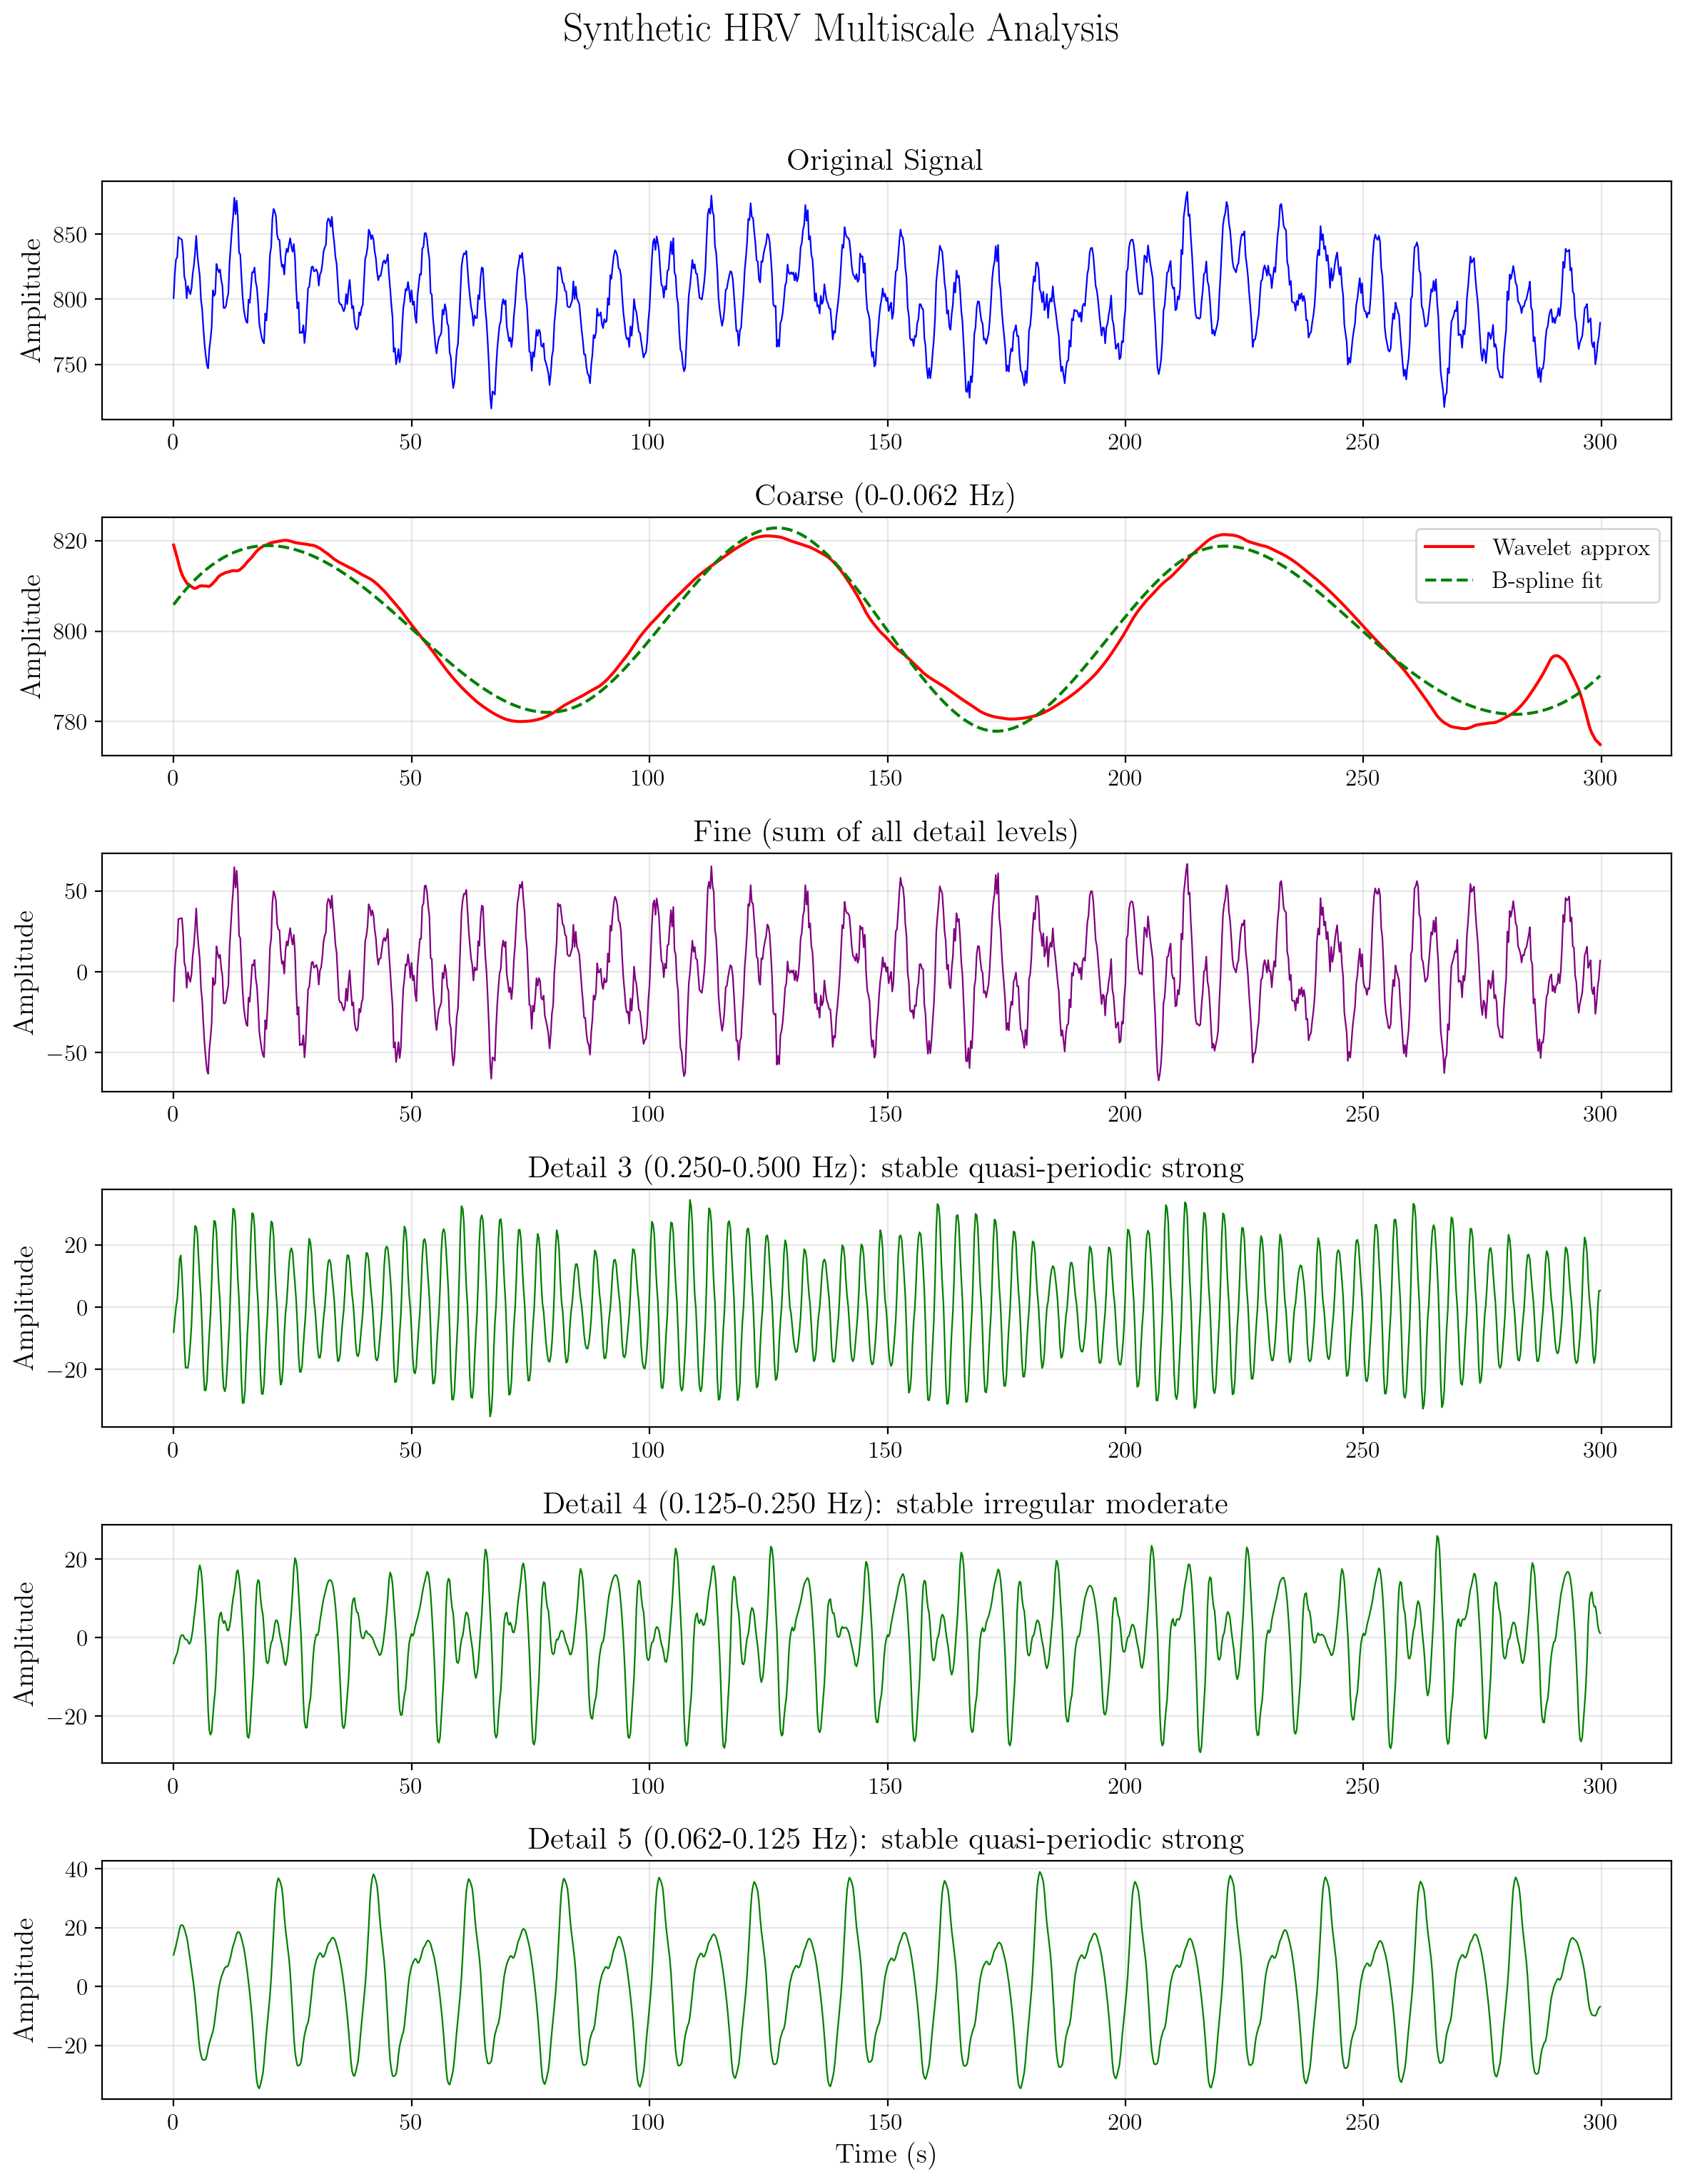

In [20]:
# Demo 1: Automated scale selection on synthetic HRV training set
print("\n" + "=" * 70)
print("DEMO 1: AUTOMATED SCALE SELECTION")
print("=" * 70)

# Generate a "training set" of synthetic HRV signals
fs = 4
duration = 300
training_set = []
for _ in range(10):  # 10 training trajectories
    _, rr = generate_synthetic_hrv(duration, fs)
    training_set.append(rr)

# Run automated scale selection
J_star, active_bands, band_info = select_active_scales(training_set, fs, threshold=0.05)
print_scale_selection(J_star, active_bands, band_info, fs)

# Demo 2: Run HRV analysis with selected scales
print("\n")
t, rr, desc = run_hrv_demo()

# Demo 3: Run comparison
run_comparison()

plt.show()